In [ ]:
!pip install pandas matplotlib nltk scikit-learn pymorphy3 mlflow-skinny flask waitress gunicorn numpy

In [ ]:
!pip install mlflow

## Классификация запросов в техподдержку ХЗ-Банка

### Датасет:
Синтезирован при помощи GPT-5 Thinking

#### Формат:

``ID:TEXT:LABEL``

#### Содержит 1000 запросов разного рода

- ``PAYMENT_OUT_FAIL``   
- ``INCOMING_DELAY``   
- ``APP_LOGIN``         
- ``CARD_ISSUE``        
- ``ACCOUNT_SEIZED``
- ``FRAUD_SUSPECTED``    
- ``KYC_VERIFICATION``  
- ``APP_TECH``

### Задачи:

- проанализировать содержимое датасета
- обучить модель классифицировать обращения по их типу
- сохранить эксперимент вместе с моделью, метриками и графиками при помощи ``MLflow``

### Стек:

- ``TF-IDF vectorizer``
- ``RandomForestClassifier``

### Загружаем данные

In [5]:
import pandas as pd

data_path = "C:\\Users\\79518\\OneDrive\\Desktop\\jupyter\\datasets\\requests-helpdesk-synthesized\\dataset.csv"

df = pd.read_csv(data_path, sep=";", encoding="cp1251")
df.head()

,ID,text,label
0,1,"Регулярный платёж списался частично, остаток в...",PAYMENT_OUT_FAIL
1,2,задержка по кэшбэку уже 9 рабочих дней когда н...,INCOMING_DELAY
2,3,Face ID крутится и возвращает на экран логина....,APP_LOGIN
3,4,аналитика расходов крутится бесконечно данных ...,APP_TECH
4,5,звонили представились банком просили код ничег...,FRAUD_SUSPECTED


### Небольшой анализ

In [7]:
counts_label = df["label"].value_counts()

print(f"Columns: {len(df)}")

df_copy = df.copy()
df_copy["text_length"] = [len(text) for text in df["text"]]
df_copy.head()

Columns: 1000


,ID,text,label,text_length
0,1,"Регулярный платёж списался частично, остаток в...",PAYMENT_OUT_FAIL,66
1,2,задержка по кэшбэку уже 9 рабочих дней когда н...,INCOMING_DELAY,53
2,3,Face ID крутится и возвращает на экран логина....,APP_LOGIN,61
3,4,аналитика расходов крутится бесконечно данных ...,APP_TECH,54
4,5,звонили представились банком просили код ничег...,FRAUD_SUSPECTED,70


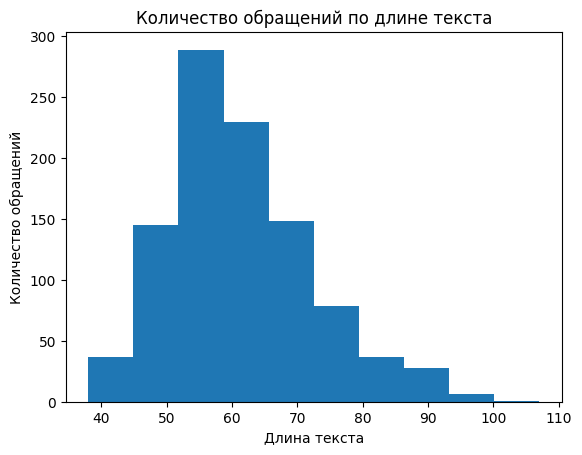

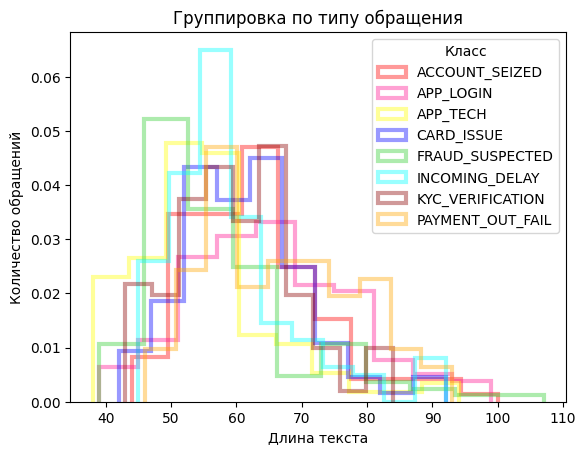

In [8]:
import matplotlib.pyplot as plt

df_ = df_copy[["text_length", "label"]]
df_.head()

plt.figure()
plt.hist(df_["text_length"])
plt.xlabel("Длина текста")
plt.ylabel("Количество обращений")
plt.title("Количество обращений по длине текста")
plt.show()

# палитра по классам для лучшего цветовосприятия
class_colors = {'ACCOUNT_SEIZED': '#FF0000',
                'APP_LOGIN': '#FF1493',
                'APP_TECH': '#FFFF00',
                'CARD_ISSUE': '#0000FF',
                'FRAUD_SUSPECTED': '#32cd32',
                'INCOMING_DELAY': '#00FFFF',
                'KYC_VERIFICATION': '#8B0000',
                'PAYMENT_OUT_FAIL': '#FFA500'} 

plt.figure()
for name, g in df_.groupby("label"):
    plt.hist(g["text_length"], histtype="step", linewidth=3, label=str(name), alpha=0.4, density=True, color=class_colors[name])
plt.legend(title="Класс")
plt.xlabel("Длина текста")
plt.ylabel("Количество обращений")
plt.title("Группировка по типу обращения")
plt.show()

Как можно заметить, среди классов нет особых различий по длине сообщения, так что данный признак нет смысла использовать в обучении.

В таком случае, мы можем воспользоваться ``TD-IDF`` для создания эмбеддингов текста, и классифицировать сообщения по ним

In [ ]:
# Для обработки текста
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Для лемматизации
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [11]:
words = stopwords.words("russian")

def remove_stopwords(text):
    text = text.split()
    text = [word for word in text if word not in words]
    return " ".join(text)

def lemmatize(text):
    text = text.split(' ')
    text_lemmatized = [list(morph.parse(word)[0])[2] for word in text]
    return " ".join(text_lemmatized)

def clean_text(text):
    text = re.sub(r',', ' ', text)
    text = re.sub(r'\"', '', text)
    text = re.sub(r'«', '', text)
    text = re.sub(r'»', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text

df_copy["clean_text"] = [clean_text(text) for text in df_copy["text"]]

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models.signature import infer_signature

# Создаем MLflow эксперимент
mlflow.set_experiment("bank_support_clf")

# Готовим данные для обучения
texts = df_copy["clean_text"]
labels = df_copy["label"]

# Инициализируем и применяем TFIDF-векторизатор
print('start vectorizer')
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=2)
X = vectorizer.fit_transform(texts)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=78)

start vectorizer


Accuracy: 0.935
                  precision    recall  f1-score   support

  ACCOUNT_SEIZED       1.00      0.96      0.98        28
       APP_LOGIN       0.88      0.91      0.89        23
        APP_TECH       1.00      1.00      1.00        18
      CARD_ISSUE       0.94      1.00      0.97        32
 FRAUD_SUSPECTED       0.96      0.88      0.92        25
  INCOMING_DELAY       0.89      0.89      0.89        28
KYC_VERIFICATION       0.96      0.90      0.93        29
PAYMENT_OUT_FAIL       0.84      0.94      0.89        17

        accuracy                           0.94       200
       macro avg       0.93      0.94      0.93       200
    weighted avg       0.94      0.94      0.94       200



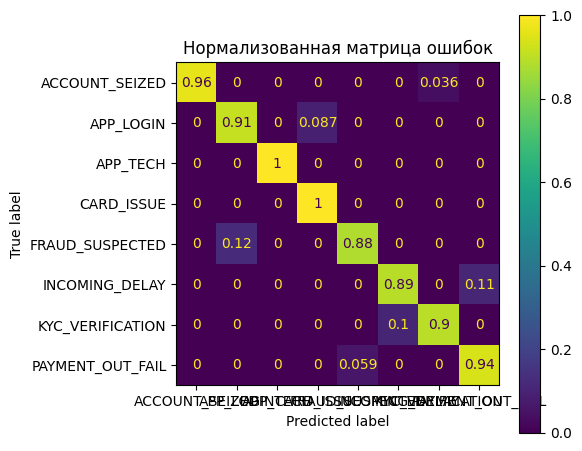

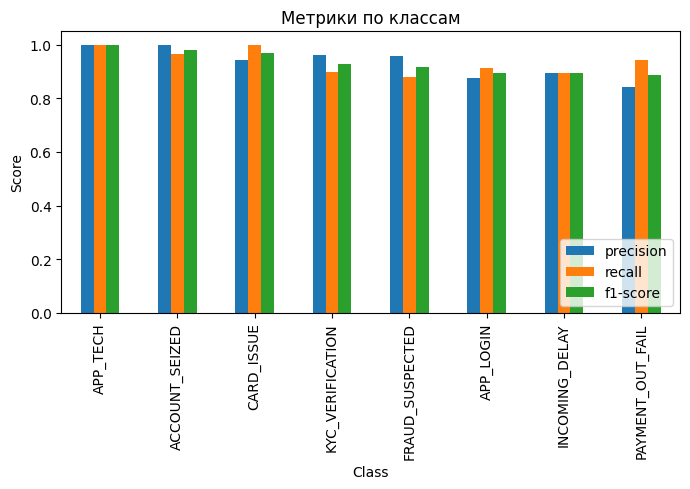

🏃 View run lr_no_pipeline at: http://localhost:5000/#/experiments/0/runs/a49532ab65044ac5ac3dea9b61207a33
🧪 View experiment at: http://localhost:5000/#/experiments/0
Проверим на придуманном образце:


array(['APP_LOGIN'], dtype=object)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,
    roc_curve, auc, precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize
import joblib, mlflow

# Инициализируем хост для MLflow
mlflow.set_tracking_uri(r"http://localhost:5000/")

# Инициализируем модель на основе логрега
lgr = LogisticRegression(max_iter=1000, random_state=78)

# Оборачиваем логику модели в MLflow-скрипты
with mlflow.start_run(run_name="lr_no_pipeline"):
    # Сохраняем параметры
    mlflow.log_params({
        "vectorizer_ngram_range": str(vectorizer.ngram_range),
        "vectorizer_min_df": vectorizer.min_df,
        "vectorizer_max_features": vectorizer.max_features,
        "lr_C": lgr.C,
        "lr_max_iter": lgr.max_iter,
        "seed": 78
    })

    # Обучаем модель
    lgr.fit(X_train, y_train)

    # Предсказываем на тестовой выборке
    y_pred = lgr.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Сохраняем метрики
    mlflow.log_metrics({
        "acc": accuracy_score(y_test, y_pred),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "f1_weighted": f1_score(y_test, y_pred, average="weighted"),
    })
    mlflow.log_dict(classification_report(y_test, y_pred, output_dict=True, zero_division=0),
                    "reports/classification_report.json")

    # Выводим и сохраняем графики
    fig, ax = plt.subplots(figsize=(6,5))
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, normalize="true", ax=ax
    )
    ax.set_title("Нормализованная матрица ошибок")
    plt.tight_layout()
    plt.show()
    mlflow.log_figure(fig, "plots/confusion_matrix.png")
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    df_rep = (pd.DataFrame(report)
              .T.drop(index=["accuracy","macro avg","weighted avg"]))
    df_rep = df_rep.sort_values("f1-score", ascending=False)
    
    fig, ax = plt.subplots(figsize=(7,5))
    df_rep[["precision","recall","f1-score"]].plot(kind="bar", ax=ax)
    ax.set_title("Метрики по классам")
    ax.set_xlabel("Class")
    ax.set_ylabel("Score")
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    mlflow.log_figure(fig, "plots/metrics.png")

    joblib.dump(vectorizer, "vectorizer.joblib")
    joblib.dump(lgr, "logreg.joblib")
    mlflow.log_artifact("vectorizer.joblib")
    mlflow.log_artifact("logreg.joblib")


print('Проверим на придуманном образце:')
test_sample = ["Не дает войти в аккаунт"]
test_vec = vectorizer.transform(test_sample)

lgr.predict(test_vec)

Выше представлена нормализованная по строкам матрица ошибок и столбчатые диаграммы precision/recall/F1 по классам для модели ``LogisticRegression`` на основе векторизованного через ``TF-IDF`` датасета. 

**Общая картина:** Качество модели высокое: по большинству классов доля верных предсказаний находится в диапазоне 0.89–1.00. Это подтверждается и метриками на класс: значения ``precision``, ``recall`` и ``F1-score`` по всем классам держатся на уровнях ≈0.88–1.00.

**Классы с наилучшими показателями:**

``APP_TECH``, ``CARD_ISSUE``, ``ACCOUNT_SEIZED`` — диагональные значения близки к 1.0, а ``precision/recall/F1`` — на уровне ≈0.95–1.00.

**Зоны наибольшей путаницы (по матрице ошибок):**

- Взаимные смешения ``APP_LOGIN`` <-> ``FRAUD_SUSPECTED`` (порядка 8–12% от соответствующих классов).
- Частые ошибки ``KYC_VERIFICATION`` -> ``APP_LOGIN`` (около 10%).
- Взаимные смешения ``INCOMING_DELAY`` -> ``PAYMENT_OUT_FAIL`` (примерно 6–11%).

Эти пары семантически близки, что объясняет их перепутывание. При этом даже для «проблемных» пар ``F1-score`` остаётся высоким (≈0.88–0.92), что указывает на устойчивость модели.

Базовый логистический классификатор обеспечивает стабильное и высокое качество по всем целевым классам. Небольшие ошибки носят системный характер и сосредоточены в логически близких категориях (``APP_LOGIN/FRAUD_SUSPECTED``, ``KYC_VERIFICATION/APP_LOGIN``, ``INCOMING_DELAY/PAYMENT_OUT_FAIL``).